# Gurobi × 機械学習による価格最適化

本プロジェクトでは、数理最適化ソルバー「Gurobi」と機械学習モデルを組み合わせることで、実際のビジネスにおける価格戦略の最適化をどのように実現できるかを紹介します。

従来の価格設定では、売上実績や経験に基づく手動の調整が主流でしたが、機械学習を用いて需要を予測し、その予測結果を最適化モデルに組み込むことで、より高精度かつ自動的な意思決定が可能となります。

このページでは、以下の内容を中心に説明します：

- `gurobi-machinelearning` パッケージの基本的な使い方  
- 学習済みモデル（線形回帰・決定木・ニューラルネットなど）をGurobiに組み込む方法  
- 価格最適化のユースケースとその数理モデルの構築  
- Gurobi 10.0でのパフォーマンス改善の効果  
- 実行結果の可視化とその解釈  

Gurobi と機械学習の融合は、単なる予測から一歩進んで「最適なアクション」を導き出す、次世代の意思決定支援の形です。数理最適化とAIの力を実務にどう応用するかを学びたい方に、ぜひ参考にしていただきたい内容です。




# 小売価格の最適化

小売価格の最適化とは、小売業者が利益を最大化するために販売する商品の価格を設定するプロセスです。目標は、顧客を引きつけて販売を促進しつつ、利益率も最大化できる最適な価格ポイントを見つけることです。小売業者は、競合分析、顧客セグメンテーション、価格テストなど、さまざまな手法を用いて価格を最適化します。

競合分析とは、競合他社が提供する類似商品の価格を監視し、それに応じて自社の価格を調整することです。顧客セグメンテーションとは、顧客を購買行動に基づいてグループに分け、それぞれのグループに適した価格を設定することです。価格テストとは、異なる価格帯を試してみて、どの価格が利益を最大化するかを見極める方法です。

このような取り組みにより、小売業者は利益を増加させ、市場での競争力を高めることが可能になります。価格最適化には、顧客の行動、市場の動向、価格戦略に関する深い理解が必要です。また、売上や価格に関するデータの収集・分析能力も求められます。価格をうまく最適化できる小売業者は、大きな競争優位性を獲得できると同時に、顧客に対して公正で妥当な価格で商品を提供することができます。

### 価格はどのように最適化されるのか？

既存製品に関するさまざまな特徴量を活用することで、 回帰分析（Regression）を使って最適な価格を見つけることができます。これらの特徴量には、競合他社の価格や評価も含まれます。競合他社の価格戦略を分析することは、小売価格を最適化する上で非常に重要です。競合他社の価格を監視・ベンチマークすることで、自社のポジショニングや戦略に応じて、競合より安く、または高く価格を設定する機会を見出すことができます。

さらに、こうした特徴量には時間的要因（例えば、特定商品の売上の時系列データ）も含まれ、\*\*需要予測（Demand Forecasting）\*\*が必要となることもあります。商品の合計価格、顧客数、販売数量といったデータは、小売業者が利益を最大化できる「スイートスポット（最適価格帯）」を見つけるのに役立ちます。

最後に、もし顧客データが十分に揃っていれば、\*\*クラスタリング（Clustering）\*\*を用いて顧客を異なるグループに分類することが可能であり、特定の商品に対して特定の顧客層に向けた価格戦略を立てやすくなります。


<div class="alert alert-success" role="alert">
 <h3>このプロジェクトで行うこと</h3> <ul> <li>複数の商品を含む小売データの探索的データ解析（EDA）</li>
 <li>最適な価格を予測するための回帰モデル作成</li> 
 <li>回帰モデル,Gurobiを用いた小売価格最適化</li> 
 </ul> </div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import eli5
from eli5.sklearn import PermutationImportance
import shap

# Loading Data

In [3]:
path = "retail_price.csv"

df = pd.read_csv(path)
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
product_id,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1,bed1
product_category_name,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table,bed_bath_table
month_year,01-05-2017,01-06-2017,01-07-2017,01-08-2017,01-09-2017,01-10-2017,01-11-2017,01-12-2017,01-01-2018,01-02-2018
qty,1,3,6,4,2,3,11,6,19,18
total_price,45.95,137.85,275.7,183.8,91.9,137.85,445.85,239.94,759.81,719.82
freight_price,15.1,12.933333,14.84,14.2875,15.1,15.1,15.832727,15.23,16.533684,13.749444
unit_price,45.95,45.95,45.95,45.95,45.95,45.95,40.531818,39.99,39.99,39.99
product_name_lenght,39,39,39,39,39,39,39,39,39,39
product_description_lenght,161,161,161,161,161,161,161,161,161,161
product_photos_qty,2,2,2,2,2,2,2,2,2,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

### Shape of the Dataset

In [5]:
print(f"Columns: {df.shape[1]}\nSamples: {df.shape[0]}")

Columns: 30
Samples: 676


### Checking for NA values

In [6]:
any(df.isna().sum() > 0)

False

### Some Stats ...

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty,676.0,14.495562,15.443421,1.000000,4.000000,10.000000,18.000000,122.00
total_price,676.0,1422.708728,1700.123100,19.900000,333.700000,807.890000,1887.322500,12095.00
freight_price,676.0,20.682270,10.081817,0.000000,14.761912,17.518472,22.713558,79.76
unit_price,676.0,106.496800,76.182972,19.900000,53.900000,89.900000,129.990000,364.00
product_name_lenght,676.0,48.720414,9.420715,29.000000,40.000000,51.000000,57.000000,60.00
product_description_lenght,676.0,767.399408,655.205015,100.000000,339.000000,501.000000,903.000000,3006.00
product_photos_qty,676.0,1.994083,1.420473,1.000000,1.000000,1.500000,2.000000,8.00
product_weight_g,676.0,1847.498521,2274.808483,100.000000,348.000000,950.000000,1850.000000,9750.00
product_score,676.0,4.085503,0.232021,3.300000,3.900000,4.100000,4.200000,4.50
customers,676.0,81.028107,62.055560,1.000000,34.000000,62.000000,116.000000,339.00


# Exploratory Data Analysis

In [8]:
fig = px.histogram(df,
                   x='total_price',
                   nbins=20,
                   title='Distribution of Total Price')
fig.show()

In [9]:
fig = px.histogram(df,
                   x='qty',
                   nbins = 100,
                   title='Distribution of qty')
fig.show()

In [10]:
fig = px.box(df,
             y='unit_price',
             title='Distribution of Unit Price')
fig.show()

In [11]:
fig = px.scatter(df,
                 x='qty',
                 y='total_price', trendline='ols',
                 title='Quantity vs Total Price')
fig.show()

In [12]:
fig = px.scatter(df,
                 x='customers',
                 y='qty', trendline='ols',
                 title='qty vs customers_x')
fig.show()

In [13]:
fig = px.bar(df, x='product_category_name',
             y='total_price', title='Total Price by Product Category')
fig.show()

In [14]:
fig = px.bar(df, x='product_category_name',
             y='unit_price', title='Unit Price by Product Category')
fig.show()

In [15]:
fig = px.box(df, x='weekday', 
             y='total_price', 
             title='Box Plot of Total Price by number of Weekdays in a Month')
fig.show()

In [16]:
fig = px.box(df, x='weekend', 
             y='total_price', 
             title='Box Plot of Total Price by number of Weekend days in a Month')
fig.show()

### Comparison with Competitor Products

As mentioned previously, competitor analysis is quite essential. Therefore, we compare the unit and shipping prices of every product to those of 3 different competitors.
* For this, we simply calculate the difference between each pair

### Price

In [17]:
df['comp1_diff'] = df['unit_price'] - df['comp_1']
df['comp2_diff'] = df['unit_price'] - df['comp_2']
df['comp3_diff'] = df['unit_price'] - df['comp_3']

for i in range(1,4):
    comp = f"comp{i}_diff"
    fig = px.bar(x=df['product_category_name'],
                 y=df[comp],
                 title=f"Competitor {i} Price Difference per Unit",
                 labels={
                     'x': 'Product Category',
                     'y': f'Competitor {i}'
                 })
    fig.show()

### Freight Price

In [18]:
df['fp1_diff'] = df['freight_price'] - df['fp1']
df['fp2_diff'] = df['freight_price'] - df['fp2']
df['fp3_diff'] = df['freight_price'] - df['fp3']

for i in range(1,4):
    comp = f"comp{i}_diff"
    fig = px.bar(x=df['product_category_name'],
                 y=df[comp],
                 title=f"Competitor {i} Shipping Price Difference",
                 labels={
                     'x': 'Product Category',
                     'y': f'Competitor {i}'
                 })
    fig.show()

### Month-wise Sales Analysis

This dataset includes features that are **temporal** in nature. The attributes of each product (sales, quantity, etc) are shown over a span of several months. Hence, we take a look at this data aggregated across time.

In [19]:
monthly_df = df.groupby(by=["product_id",'month_year']).agg({
    'unit_price': 'mean', 'total_price': 'sum', 'freight_price': 'sum',
    'qty': 'sum', 'weekday': 'sum', 'weekend': 'sum', 'customers': 'sum'
}).reset_index()
monthly_df['month_year'] = pd.to_datetime(monthly_df['month_year'], format='%d-%m-%Y')
monthly_df = monthly_df.sort_values(by='month_year')

In [20]:
fig = px.scatter(monthly_df,
                 x='customers', y='total_price', trendline='ols',
                 title='Total Price vs Number of Customers')
fig.show()

In [21]:
fig = px.scatter(monthly_df,
             x='weekend', y='total_price', trendline='ols',
             title='Weekly Analysis of Total Price')
fig.show()

In [22]:
fig = px.bar(monthly_df,
             x='month_year', y='customers',
             title='Customers per month')
fig.show()

# Feature Engineering

### Creating an aggregated dataframe by products

Since the data involves recurring products across months, we create an aggregated dataframe to proceed with the problem. This is because we will be using **Regression Analysis**. Some of the features get dropped based on the Correlation Analysis results. With the remaining -
* Features like total_price, number of customers are aggregated by their sum
* Others, such as competitor differences, product score, unit price, are all aggregated by thier mean

In [23]:
cols_to_mean = ['product_id', 'comp1_diff', 'comp2_diff', 'comp3_diff',
                'fp1_diff', 'fp2_diff', 'fp3_diff', 'product_score', 'unit_price']
cols_to_sum = ['product_id', 'total_price', 'freight_price', 'customers']
mean_df = df[cols_to_mean]
sum_df = df[cols_to_sum]

### Aggregating the dataframes separately, based on type

In [24]:
products_mean = mean_df.groupby(by='product_id').mean()
products_sum = sum_df.groupby(by='product_id').sum()

### Join the dataframes

In [25]:
products = pd.concat([products_sum, products_mean],
                     axis=1, join='inner').reset_index()

In [26]:
df_category = df[["product_id","product_category_name"]]
category_dict = dict(zip(df_category["product_id"], df_category["product_category_name"]))


In [27]:
monthly_product = pd.merge(monthly_df,products,on= "product_id",how = "inner")
monthly_product = pd.merge(monthly_product,df_category,on = "product_id",how = "inner")

## 邪魔になりうる入力を削減

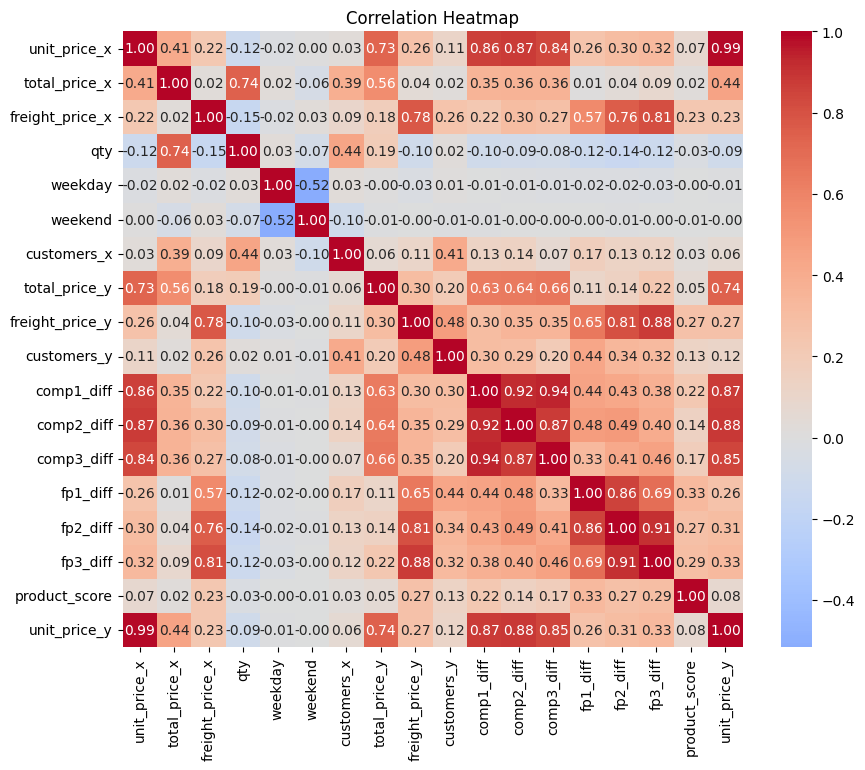

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 数値データの相関係数を計算
corr_matrix = monthly_product.corr(numeric_only=True)

# ヒートマップの描画
plt.figure(figsize=(10, 8))  # サイズ調整（任意）
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [29]:
import numpy as np
import pandas as pd

def add_cyclic_date_features(df, date_col, drop_original=False):
    """
    日付列から周期性を考慮した特徴量（sin/cos）を追加する関数。
    
    Parameters:
        df : pandas.DataFrame
            処理対象のデータフレーム
        date_col : str
            日付が格納されている列の名前（datetime型である必要あり）
        drop_original : bool
            month, day, weekday などの元列を削除するかどうか
        
    Returns:
        df : pandas.DataFrame
            特徴量が追加されたデータフレーム
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])  # 念のため型変換

    # 時間情報の抽出
    df["year"] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday  # 月:0〜日:6
    df.drop(date_col,axis = 1,inplace= True)

    # 周期性を考慮した変換
    # df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    # df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    # df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    # df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    # df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

    # if drop_original:
        # df.drop([date_col], axis=1, inplace=True)

    return df


In [30]:
cycle_month_products = add_cyclic_date_features(monthly_product,date_col = "month_year",drop_original=True)
cycle_month_products = cycle_month_products.drop("total_price_x",axis=1)

# Model Building

Retail price optimization can be tackled as a regression problem, where the objective is to predict the optimal price for a given product, based on various factors such as product features, competitor prices, and customer behavior. **Regression** is a statistical technique used to analyze the relationship between two or more variables. It is commonly used to predict a dependent variable based on one or more independent variables, by modeling the relationship between them. The basic idea behind regression is to find the line or curve that best fits the data, so that we can use it to make predictions for new data points.

Here we are making use of **RandomForestRegressor**, a popular regression technique based on the Bagging method of Ensemble learning, Random Forest.

**Note**: The goal here is not to build the best model, but to highlight how this problem can be solved, and further deriving some business value through this solution, which will be done in a later section.

Anyways, onto the model

## ターゲットの年とprduct_id、その種類を定義

In [65]:
target_year = 2017
target_product = "health5"
target_category = category_dict[target_product]
model_dataset = cycle_month_products[(cycle_month_products["year"] == target_year) &(cycle_month_products["product_category_name"] == target_category) ] 
target_qty = cycle_month_products[(cycle_month_products["year"] == target_year) & (cycle_month_products["product_id"] == target_product)]
# target_qty.drop(["product_category_name"],inplace= True,axis=1)

In [78]:
not_fe = ["product_id","qty","product_category_name","year","month","day"]#学習に用いわない特徴量
target = "qty"

X = model_dataset.drop(not_fe,axis=1)
y = model_dataset["qty"]
pipeline = Pipeline([
    ("regressor", LinearRegression())
])

# モデルの学習（.fit）
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

print(f"R2 score: {r2_score(y, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y, y_pred)}")

fig = go.Figure()
fig.add_trace(go.Scatter(x=y, y=y_pred, mode='markers', 
                         marker=dict(color='blue'), 
                         name='Predicted vs. Actual Retail qty'))
fig.add_trace(go.Scatter(x=[min(y), max(y)], y=[min(y), max(y)], 
                         mode='lines', 
                         marker=dict(color='red'), 
                         name='Ideal Prediction'))
fig.update_layout(
    title='Predicted vs. Actual Retail qty',
    xaxis_title='Actual Retail qty',
    yaxis_title='Predicted Retail qty'
)
fig.show()

R2 score: 0.6316745002070048
Mean Absolute Error: 3.9803771974633837


## 年ごとの在庫量を構築。qtyの年ごとの和を取得している

In [68]:
stock = pd.DataFrame(cycle_month_products.groupby(["product_id","year"]).sum()["qty"]).reset_index()
target_stock = stock[(stock["product_id"] == target_product) & (stock["year"] == target_year)]["qty"]

## gurobiを使って定式化

In [69]:
import gurobipy as gp
from gurobi_ml import add_predictor_constr
import gurobipy_pandas as gppd

In [70]:
unit_min = target_qty["unit_price_x"].min()
unit_max = target_qty["unit_price_x"].max()

In [83]:


#定式化
m = gp.Model()

#変数を定義
# discount = gppd.add_vars(m,target_qty,name = "discount",lb = 0.0,ub = 0.5)#cycle_moth_productsの各行に対してdiscountという変数を設定
# new_qty や new_price に現実的な範囲の上下限を指定する
new_qty = gppd.add_vars(m, target_qty, name="new_qty", lb=0.0, ub=1000.0)
new_price = gppd.add_vars(m, target_qty, name="new_price", lb=unit_min * 0.9, ub=unit_max * 1.1)


# #利益最大化の目的関数
revenue_expr = gp.quicksum(
    new_qty[i] * (new_price[i]) 
    for i in target_qty.index
)
m.setObjective(revenue_expr,gp.GRB.MAXIMIZE)

#制約式を定義
m.addConstr(new_qty.sum() <= target_stock )#予測される売り上げ量が年間売り上げ量以下
feats = target_qty.drop(not_fe,axis=1)
feats["unit_price_x"] = new_price


pred_constr = add_predictor_constr(m,pipeline,feats,new_qty)
m.Params.NonConvex = 2
# m.feasRelaxS(0, False, False, True)
m.optimize()



Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23H124)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2

Optimize a model with 241 rows, 4080 columns and 4320 nonzeros
Model fingerprint: 0x2d261cde
Model has 240 quadratic objective terms
Coefficient statistics:
  Matrix range     [3e-03, 1e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 5e+04]
  RHS range        [3e+00, 1e+03]
Presolve removed 0 rows and 3600 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 0 rows and 3600 columns
Presolve time: 0.00s
Presolved: 722 rows, 722 columns, 2241 nonzeros
Presolved model has 240 bilinear constraint(s)
Variable types: 722 continuous, 0 integer (0 binary)
Found heuristic solution: objective 489544.70247

Root relaxation: objective 4.922370e+05, 242 iterations, 0.00 s

In [107]:
import pandas as pd

# 最適化後の解の取得
results = []

for i in target_qty.index:
    pid = target_qty.at[i, "product_id"]
    original_qty = target_qty.at[i, "qty"]
    original_price = target_qty.at[i,"unit_price_x"]
    
    price = new_price[i].X
    qty = new_qty[i].X
    
    revenue = price * qty

    results.append({
        "product_id": pid,
        "original_qty": original_qty,
        "optimized_qty": qty,
        "original_price":original_price,
        "optimized_price": price,
        "revenue": revenue
    })

# DataFrame化して表示
results_df = pd.DataFrame(results)

# 結果表示（必要に応じてソートやフィルター）
print(results_df)  # 上位10件のみ表示（多い場合）
print("\n🔢 合計売上（最適化後）:", results_df["revenue"].sum())


    product_id  original_qty  optimized_qty  original_price  optimized_price  \
0      health5             8       0.000000      349.900000       350.446773   
1      health5             8       0.000000      349.900000       350.446773   
2      health5             8       0.000000      349.900000       350.446773   
3      health5             8       0.000000      349.900000       350.446773   
4      health5             8       0.000000      349.900000       350.446773   
5      health5             8       0.000000      349.900000       350.446773   
6      health5             8       0.000000      349.900000       350.446773   
7      health5             8       0.000000      349.900000       350.446773   
8      health5             8       0.000000      349.900000       350.446773   
9      health5             8       0.000000      349.900000       350.446773   
10     health5             8       0.000000      349.900000       350.446773   
11     health5             8       0.000

In [108]:
results_df

,product_id,original_qty,optimized_qty,original_price,optimized_price,revenue
0,health5,8,0.000000,349.900000,350.446773,0.000000
1,health5,8,0.000000,349.900000,350.446773,0.000000
2,health5,8,0.000000,349.900000,350.446773,0.000000
3,health5,8,0.000000,349.900000,350.446773,0.000000
4,health5,8,0.000000,349.900000,350.446773,0.000000
5,health5,8,0.000000,349.900000,350.446773,0.000000
6,health5,8,0.000000,349.900000,350.446773,0.000000
7,health5,8,0.000000,349.900000,350.446773,0.000000
8,health5,8,0.000000,349.900000,350.446773,0.000000
9,health5,8,0.000000,349.900000,350.446773,0.000000


In [88]:
original_revenue = target_qty["unit_price_x"] * target_qty["qty"]

In [89]:
sum(original_revenue)

441763.99999199994

In [90]:
results_df["original_revenue"] = results_df["original_qty"] * results_df["optimized_price"]  # 比較用
results_df["delta_qty"] = results_df["optimized_qty"] - results_df["original_qty"]
results_df["delta_revenue"] = results_df["revenue"] - results_df["original_revenue"]


In [91]:
import plotly.graph_objects as go
import plotly.express as px

# ① 数量の比較バーグラフ
fig_qty = go.Figure()
fig_qty.add_trace(go.Bar(
    x=results_df["product_id"], y=results_df["original_qty"],
    name="Original Qty", marker_color="lightgray"
))
fig_qty.add_trace(go.Bar(
    x=results_df["product_id"], y=results_df["optimized_qty"],
    name="Optimized Qty", marker_color="blue"
))
fig_qty.update_layout(
    title="🔢 商品ごとの数量変化（最適化前 vs 最適化後）",
    xaxis_title="Product ID", yaxis_title="Quantity",
    barmode="group", height=400
)

# ② 価格の比較（折れ線グラフ）
fig_price = go.Figure()
fig_price.add_trace(go.Scatter(
    x=results_df["product_id"], y=results_df["optimized_price"],
    name="Optimized Price", mode="lines+markers", line=dict(color="green")
))
fig_price.update_layout(
    title="💰 最適化後の価格（Product ID別）",
    xaxis_title="Product ID", yaxis_title="Price", height=400
)

# ③ 売上の増加（差分）ヒートマップ風バー
fig_rev = px.bar(
    results_df, x="product_id", y="delta_revenue", color="delta_revenue",
    color_continuous_scale="RdBu", title="📈 売上差分（最適化後 - 前）",
    labels={"delta_revenue": "Revenue Change"}
)
fig_rev.update_layout(height=400)

# 表示（順番に）
fig_qty.show()
fig_price.show()
fig_rev.show()


In [92]:
total_original_qty = results_df["original_qty"].sum()
total_optimized_qty = results_df["optimized_qty"].sum()
total_original_revenue = results_df["original_revenue"].sum()
total_optimized_revenue = results_df["revenue"].sum()

delta_qty = total_optimized_qty - total_original_qty
delta_revenue = total_optimized_revenue - total_original_revenue


In [93]:
import plotly.graph_objects as go

# 合計数量の変化
fig_qty_total = go.Figure(data=[
    go.Bar(name='Original Total Qty', x=["Quantity"], y=[total_original_qty], marker_color='lightgray'),
    go.Bar(name='Optimized Total Qty', x=["Quantity"], y=[total_optimized_qty], marker_color='blue')
])
fig_qty_total.update_layout(
    title="🔢 全体の数量変化（合計）",
    barmode='group',
    yaxis_title="Total Quantity"
)

# 合計売上の変化
fig_rev_total = go.Figure(data=[
    go.Bar(name='Original Total Revenue', x=["Revenue"], y=[total_original_revenue], marker_color='lightgray'),
    go.Bar(name='Optimized Total Revenue', x=["Revenue"], y=[total_optimized_revenue], marker_color='green')
])
fig_rev_total.update_layout(
    title="💰 全体の売上変化（合計）",
    barmode='group',
    yaxis_title="Total Revenue"
)

fig_qty_total.show()
fig_rev_total.show()


In [95]:
import plotly.express as px

scatter_data = results_df.copy()
scatter_data["original_price"] = scatter_data["revenue"] / scatter_data["optimized_qty"]  # 推定元価格

fig_scatter = px.scatter(
    scatter_data,
    x="optimized_price", y="optimized_qty",
    size="revenue", color="delta_revenue",
    color_continuous_scale="RdBu",
    title="📊 最適化後の価格と数量の関係（バブルサイズ：売上）",
    labels={"optimized_price": "Price", "optimized_qty": "Quantity"}
)
fig_scatter.update_layout(height=500)
fig_scatter.show()


In [94]:
import plotly.express as px

scatter_data = results_df.copy()
scatter_data["original_price"] = scatter_data["revenue"] / scatter_data["optimized_qty"]  # 推定元価格

fig_scatter = px.scatter(
    scatter_data,
    x="optimized_price", y="optimized_qty",
    size="revenue", color="delta_revenue",
    color_continuous_scale="RdBu",
    title="📊 最適化後の価格と数量の関係（バブルサイズ：売上）",
    labels={"optimized_price": "Price", "optimized_qty": "Quantity"}
)
fig_scatter.update_layout(height=500)
fig_scatter.show()


In [96]:
summary = pd.DataFrame({
    "Metric": ["Total Quantity", "Total Revenue", "Quantity Change", "Revenue Change"],
    "Before Optimization": [total_original_qty, total_original_revenue, None, None],
    "After Optimization": [total_optimized_qty, total_optimized_revenue, delta_qty, delta_revenue]
})
print(summary)


            Metric  Before Optimization  After Optimization
0   Total Quantity          1280.000000        1.280000e+03
1    Total Revenue        459088.590417        4.921967e+05
2  Quantity Change                  NaN       -9.094947e-13
3   Revenue Change                  NaN        3.310808e+04


In [100]:
import plotly.express as px

results_df["original_price"] = X["unit_price_x"]
fig_price_change = px.scatter(
    results_df,
    x="original_price",
    y="optimized_price",
    hover_name="product_id",
    title="💸 元価格 vs 最適化後価格",
    labels={"original_price": "Original Price", "optimized_price": "Optimized Price"},
    color_discrete_sequence=["blue"]
)

# 理想線（価格が変わらなかった点線）を追加
fig_price_change.add_shape(
    type="line",
    x0=results_df["original_price"].min(),
    y0=results_df["original_price"].min(),
    x1=results_df["original_price"].max(),
    y1=results_df["original_price"].max(),
    line=dict(color="red", dash="dash"),
    name="No Change Line"
)

fig_price_change.update_layout(
    xaxis=dict(title="元の価格"),
    yaxis=dict(title="最適化後の価格"),
    height=500
)

fig_price_change.show()


In [36]:
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

from gurobi_ml import add_predictor_constr
import gurobipy_pandas as gppd


In [37]:
# Get the data

data_url = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/"
avocado = pd.read_csv(
    data_url + "HABdata_2019_2022.csv"
)  # dataset downloaded directly from HAB
print(avocado.head())
avocado_old = pd.read_csv(
    data_url + "kaggledata_till2018.csv"
)  # dataset downloaded from Kaggle
print(avocado_old.head())
avocado = pd.concat([avocado, avocado_old])

# Add the index for each year from 2015 through 2022
avocado["date"] = pd.to_datetime(avocado["date"])
avocado["year"] = pd.DatetimeIndex(avocado["date"]).year
avocado["year_index"] = avocado["year"] - 2015
avocado = avocado.sort_values(by="date")

# Define the peak season
avocado["month"] = pd.DatetimeIndex(avocado["date"]).month
peak_months = range(2, 8)  # <--------- Set the months for the "peak season"


def peak_season(row):
    return 1 if int(row["month"]) in peak_months else 0


avocado["peak"] = avocado.apply(lambda row: peak_season(row), axis=1)

# Scale the number of avocados to millions
avocado["units_sold"] = avocado["units_sold"] / 1000000

# Select only conventional avocados
avocado = avocado[avocado["type"] == "Conventional"]

avocado = avocado[
    ["date", "units_sold", "price", "region", "year", "month", "year_index", "peak"]
].reset_index(drop=True)

        region          date          type     price  units_sold
0  Great_Lakes   1/7/19 0:00  Conventional  1.106743  3812441.96
1  Great_Lakes   1/7/19 0:00       Organic  1.371280   275987.52
2  Great_Lakes  1/13/19 0:00  Conventional  1.063457  3843318.68
3  Great_Lakes  1/13/19 0:00       Organic  1.493384   244991.95
4  Great_Lakes  1/20/19 0:00  Conventional  1.049931  4587957.69
        region     date          type  price  units_sold
0  Great_Lakes   1/4/15  Conventional   1.02  3382800.12
1  Great_Lakes   1/4/15       Organic   1.54    61615.10
2  Great_Lakes  1/11/15  Conventional   1.10  3067638.32
3  Great_Lakes  1/11/15       Organic   1.69    58061.65
4  Great_Lakes  1/18/15  Conventional   1.08  3006207.02


In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder="drop",
)


regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains",
]
df = avocado[avocado.region.isin(regions)]

X = df[["region", "price", "peak"]]
y = df["units_sold"]

In [40]:
X.head()

,region,price,peak
0,Great_Lakes,1.02,0
1,Midsouth,1.10,0
2,West,0.89,0
3,Southeast,0.98,0
4,Northern_New_England,1.05,0


In [41]:

from sklearn.model_selection import train_test_split

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)


In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone
# from xgboost import XGBRegressor
from time import time

args = {"random_state": 1}
regressions = {
    "Linear Regression": {"regressor": LinearRegression()},
    "MLP Regression": {"regressor": MLPRegressor([8] * 2, max_iter=1000, **args)},
    "Decision Tree": {"regressor": DecisionTreeRegressor(max_leaf_nodes=50, **args)},
    "Random Forest": {
        "regressor": RandomForestRegressor(n_estimators=10, max_leaf_nodes=100, **args)
    },
    "Gradient Boosting": {
        "regressor": GradientBoostingRegressor(n_estimators=20, **args)
    },
}

# Add polynomial features for linear regression and MLP
regressions_poly = {}
for regression in ["Linear Regression", "MLP Regression"]:
    data = {
        "regressor": (PolynomialFeatures(), clone(regressions[regression]["regressor"]))
    }
    regressions_poly[f"{regression} polynomial feats"] = data
# Merge dictionary of polynomial features
regressions |= regressions_poly

In [53]:

for regression, data in regressions.items():
    regressor = data["regressor"]
    if isinstance(regressor, tuple):
        lin_reg = make_pipeline(feat_transform, *regressor)
    else:
        lin_reg = make_pipeline(feat_transform, regressor)
    train_start = time()
    lin_reg.fit(X_train, y_train)
    data[("Learning", "time")] = time() - train_start
    data["pipeline"] = lin_reg

    # Get R^2 from test data
    y_pred = lin_reg.predict(X_test)
    r2_test = r2_score(y_test, y_pred)
    y_pred = lin_reg.predict(X_train)
    r2_train = r2_score(y_train, y_pred)
    data[("Learning", "R2 test")] = r2_test
    data[("Learning", "R2 train")] = r2_train
    print(
        f"{regression:<18} R^2 value in the test set is {r2_test:.3f} training {r2_train:.3f}"
    )


Linear Regression  R^2 value in the test set is 0.868 training 0.882
MLP Regression     R^2 value in the test set is 0.883 training 0.894
Decision Tree      R^2 value in the test set is 0.882 training 0.906
Random Forest      R^2 value in the test set is 0.874 training 0.924
Gradient Boosting  R^2 value in the test set is 0.802 training 0.829
Linear Regression polynomial feats R^2 value in the test set is 0.884 training 0.894
MLP Regression polynomial feats R^2 value in the test set is 0.887 training 0.897


In [209]:

# Sets and parameters
B = 30  # total amount ot avocado supply

peak_or_not = 1  # 1 if it is the peak season; 1 if isn't

c_waste = 0.1  # the cost ($) of wasting an avocado
# the cost of transporting an avocado
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    },
    name="transport_cost",
)

c_transport = c_transport.loc[regions]
# the cost of transporting an avocado

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
a_min = 0  # minimum avocado price in each region
a_max = 2  # maximum avocado price in each region

data = pd.concat(
    [
        c_transport,
        df.groupby("region")["units_sold"].min().rename("min_delivery"),
        df.groupby("region")["units_sold"].max().rename("max_delivery"),
    ],
    axis=1,
)

In [213]:
data

,transport_cost,min_delivery,max_delivery
Great_Lakes,0.3,2.063574,7.094765
Midsouth,0.1,1.845443,6.168572
Northeast,0.4,2.364424,8.836406
Northern_New_England,0.5,0.219690,0.917984
SouthCentral,0.3,3.687130,10.323175
Southeast,0.2,2.197764,7.810475
West,0.2,3.260102,11.274749
Plains,0.2,1.058938,3.575499


In [212]:
df.head()

,date,units_sold,price,region,year,month,year_index,peak
0,2015-01-04,3.382800,1.02,Great_Lakes,2015,1,0,0
1,2015-01-04,2.578275,1.10,Midsouth,2015,1,0,0
2,2015-01-04,5.794411,0.89,West,2015,1,0,0
3,2015-01-04,3.204112,0.98,Southeast,2015,1,0,0
4,2015-01-04,0.321824,1.05,Northern_New_England,2015,1,0,0


In [55]:

m = gp.Model("Avocado_Price_Allocation")

p = gppd.add_vars(m, data, name="price", lb=a_min, ub=a_max)
d = gppd.add_vars(m, data, name="demand")  # Add variables for the regression
w = m.addVar(name="w")  # excess wasteage
m.update()

m.setObjective((p * d).sum() - c_waste * w - (c_transport * d).sum())
m.ModelSense = GRB.MAXIMIZE

m.addConstr(d.sum() + w == B)
m.update()


In [56]:

feats = pd.DataFrame(
    data={"peak": peak_or_not, "region": regions, "price": p}, index=regions
)
feats = feats[["region", "price", "peak"]]


In [57]:
for regression, data in regressions.items():
    pred_constr = add_predictor_constr(m, data["pipeline"], feats, d, epsilon=1e-5)

    pred_constr.print_stats()

    data[("Optimization", "#constrs")] = m.NumConstrs + m.NumQConstrs + m.NumGenConstrs
    data[("Optimization", "#vars")] = m.NumVars
    m.Params.NonConvex = 2
    m.Params.OutputFlag = 0
    try:
        start = time()
        m.optimize()
        data[("Optimization", "time")] = time() - start
        data[("Optimization", "value")] = m.ObjVal
        data[("Optimization", "viol")] = m.MaxVio
        data[("Optimization", "error")] = pred_constr.get_error().max()
    except gp.GurobiError:
        data[("Optimization", "value")] = float("nan")
        data[("Optimization", "viol")] = float("nan")
        data[("Optimization", "error")] = float("nan")
        break
        pass
    pred_constr.remove()


Model for pipe:
72 variables
16 constraints
Input has shape (8, 3)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans             (8, 9)            8            8            0            0

lin_reg               (8, 1)           64            8            0            0

--------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Model for pipe0:
328 variables
144 constraints
128 general constraints
Input has shape (8, 3)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    

In [58]:
data

{'regressor': (PolynomialFeatures(),
  MLPRegressor(hidden_layer_sizes=[8, 8], max_iter=1000, random_state=1)),
 ('Learning', 'time'): 0.36524009704589844,
 'pipeline': Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('onehotencoder',
                                                   OneHotEncoder(drop='first'),
                                                   ['region']),
                                                  ('standardscaler',
                                                   StandardScaler(), ['price']),
                                                  ('passthrough', 'passthrough',
                                                   ['peak'])],
                                    verbose_feature_names_out=False)),
                 ('polynomialfeatures', PolynomialFeatures()),
                 ('mlpregressor',
                  MLPRegressor(hidden_layer_sizes=[8, 8], max_iter=1000,
                               random_state=1)

# Model Explainability

As a data scientist, the job simply doesn't end with building a Machine Learning model that gives the best metrics. The main idea is to derive insights that can help a business or organization improve further. This is where Machine Learning Model explainability comes in.

Model explainability is the ability to understand and interpret how a machine learning model arrives at its predictions or decisions. It is an important aspect of machine learning, especially in applications where the stakes are high, such as healthcare or finance, where decisions made by the model can have significant consequences. Explainability allows us to understand the reasoning behind a model's predictions, and helps to build trust and confidence in the model. It also helps to identify any biases or errors in the model, which can be corrected or improved to enhance the model's performance.

One important feature of Model explainability is that it can help understand how the involved features are helping the model get better- or worse. These features are raw and collected from real world scenarios, so it is important to understand how they are affecting the model's predictions. Each feature brings a certain value, positive or negative, and sometimes, both are important in building an unbiased, generalized model. These insights are simplified, so that they can be explained to the non-technical audience involved in the process. 

<div class="alert alert-success" role="alert">
    <h3>Techniques for Model Explainability</h3>
    <ul>
        <li>Permutation Importance</li>
        <li>SHAP (SHapley Additive exPlanations)</li>
        <li>SHAP summary plot</li>
    </ul>
</div>

### Permutation Importance

Permutation importance is a technique for measuring the importance of features in a machine learning model. It works by shuffling the values of a single feature in the test set and measuring the decrease in performance of the model. The idea behind this is that a feature which is important for the model's prediction should have a greater impact on the model's performance when its values are randomly permuted.

In [95]:
perm = PermutationImportance(model, random_state=1).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.9618 ± 0.1314,customers_x
0.4791 ± 0.0510,total_price_y
0.1602 ± 0.0176,customers_y
0.1183 ± 0.0125,freight_price_x
0.0818 ± 0.0063,unit_price_x
0.0716 ± 0.0209,fp1_diff
0.0698 ± 0.0079,comp1_diff
0.0538 ± 0.0068,comp2_diff
0.0353 ± 0.0060,fp3_diff
0.0327 ± 0.0051,freight_price_y


### Predictions with Largest and Smallest Error

Using SHAP values to analyze what made the best prediction, the best, and the worst one, the worst. SHAP values break down a prediction to show the impact of each feature. This can help see the effects of each feature on a single prediction. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

**Note**: SHAP values do not provide **Causality**

In [31]:
products['unit_price_pred'] = y_pred
products['error'] = abs(products['unit_price'] - products['unit_price_pred'])
products.head()

,product_id,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price,unit_price_pred,error
0,bed1,5831.77,240.410762,915,-43.976523,-47.634907,0.000000,-2.629416,-1.484667,0.000000,4.0,42.211989,42.489737,0.277748
1,bed2,42938.66,324.204152,968,0.000000,-28.547817,37.032861,0.000000,-0.989857,2.214245,3.9,86.774536,103.087462,16.312926
2,bed3,10304.96,172.316049,530,7.599892,0.000000,51.588471,-2.996105,0.000000,0.378738,3.3,92.101364,98.837131,6.735767
3,bed4,6011.77,151.576305,515,-38.826174,0.000000,6.085263,-3.644118,0.000000,-0.023987,4.2,46.725444,44.375751,2.349694
4,bed5,29997.36,96.015504,385,108.481703,0.000000,152.431703,3.761456,0.000000,4.750934,4.4,198.381703,185.783795,12.597908


In [32]:
max(products['error']), min(products['error'])

(42.57551522760048, 0.27774801323548104)

In [33]:
largest_error = products[products['error'] == max(products['error'])].drop(['product_id'], axis=1)
smallest_error = products[products['error'] == min(products['error'])].drop(['product_id'], axis=1)

### SHAP Values

In [34]:
data_for_prediction = largest_error 
print("-------------------- LARGEST ERROR PREDICTION --------------------\n\n")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

-------------------- LARGEST ERROR PREDICTION --------------------




In [35]:
data_for_prediction = smallest_error
print("-------------------- SMALLEST ERROR PREDICTION --------------------\n\n")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

-------------------- SMALLEST ERROR PREDICTION --------------------




### Inferences

* The **base value** (AKA expected value) is the average of the model output over the training data
* In the first plot, we can see the prediction was much higher than the base value. The Competitor Differences were the major factors that led to such a high prediction. Among these, `comp_diff_1` had the highest impact. The competitor difference is high, and positive, which means that the competitors are selling for much lower and the total price is quite low. This is why the model predicts a high value, so that the product does not contribute to a loss for the retailer.
* In the second plot, the prediction was much lower than the base value. The competitor difference is negative (indicating that the competitors were selling at higher prices) and a high value of `total_price` is the major contributor. This explains why the model predicted a much lower value. Because the product is already being sold at a lower price compared to the competitors and with such a high value for total price means the optimal price is fairly low.

### SHAP Summary Plot

A SHAP (SHapley Additive exPlanations) summary plot is a type of visualization that shows the impact of different features on the output of a machine learning model. It is particularly useful for regression problems, where the goal is to predict a continuous output variable based on one or more input variables.

The basic idea behind a SHAP summary plot is to display the average impact of each input feature on the model's prediction, across all instances in the dataset. The plot shows a horizontal bar for each feature, with the length of the bar representing the magnitude of the feature's impact on the output. Features that have a positive impact are shown in blue, while those that have a negative impact are shown in red.

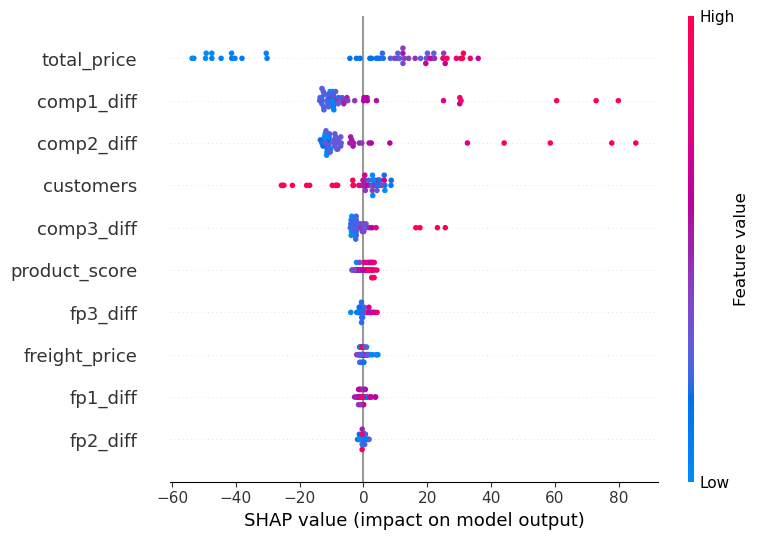

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

# Conclusion

<div class="alert alert-info">
The ultimate aim of optimizing retail prices is to charge a price that helps you make the most money and attracts enough customers to buy your products. It involves using data and pricing strategies to find the right price that maximizes your sales and profits while keeping customers happy. 
    
<strong>That's it for this one. If you like this notebook, please upvote and comment. Thank You !</strong>
</div>